In [1]:
import pandas as pd
import pickle
%config Completer.use_jedi = False

goal_set = pickle.load(open('synthetic_dataset/goal_set.p', 'rb'))
slot_set = pickle.load(open('synthetic_dataset/slot_set.p', 'rb'))


In [2]:
lengths = {key: len(value) for key, value in goal_set.items()}
lengths

{'train': 24000, 'test': 6000, 'validate': 0}

In [3]:
train_data = goal_set['train']
test_data = goal_set['test']
train_data

[{'consult_id': 1059,
  'disease_tag': 'Central retinal artery or vein occlusion',
  'group_id': '7',
  'goal': {'request_slots': {'disease': 'UNK'},
   'explicit_inform_slots': {'Spots or clouds in vision': True},
   'implicit_inform_slots': {'Diminished vision': True,
    'Symptoms of eye': True,
    'Pain in eye': True}}},
 {'consult_id': 19510,
  'disease_tag': 'Degenerative disc disease',
  'group_id': '6',
  'goal': {'request_slots': {'disease': 'UNK'},
   'explicit_inform_slots': {'Shoulder pain': True},
   'implicit_inform_slots': {'Back pain': True,
    'Low back pain': True,
    'Neck pain': True,
    'Hip pain': True,
    'Ache all over': True}}},
 {'consult_id': 25630,
  'disease_tag': 'Diabetic retinopathy',
  'group_id': '4',
  'goal': {'request_slots': {'disease': 'UNK'},
   'explicit_inform_slots': {'Foreign body sensation in eye': True},
   'implicit_inform_slots': {}}},
 {'consult_id': 1467,
  'disease_tag': 'Chronic back pain',
  'group_id': '13',
  'goal': {'request

In [4]:
# test 데이터에는 새로운 질병이나 증상이 없음을 확안

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_diseases = set(train_df['disease_tag'].unique())
train_symptoms = set()

for _, row in train_df.iterrows():
    train_symptoms.update(row['goal']['explicit_inform_slots'].keys())
    train_symptoms.update(row['goal']['implicit_inform_slots'].keys())

# 질병 및 증상 추출
test_diseases = set(test_df['disease_tag'].unique())
test_symptoms = set()

for _, row in test_df.iterrows():
    test_symptoms.update(row['goal']['explicit_inform_slots'].keys())
    test_symptoms.update(row['goal']['implicit_inform_slots'].keys())

# 트레이닝 데이터에 없는 테스트 데이터의 질병
new_diseases = test_diseases - train_diseases
# 트레이닝 데이터에 없는 테스트 데이터의 증상
new_symptoms = test_symptoms - train_symptoms

# 결과 출력
print("New Diseases in Test Data:", new_diseases)
print("New Symptoms in Test Data:", new_symptoms)

New Diseases in Test Data: set()
New Symptoms in Test Data: set()


In [5]:
unique_diseases = train_df['disease_tag'].nunique()
# 명시적 증상과 암묵적 증상 중복 없이 개수 세기
explicit_symptoms = set()
implicit_symptoms = set()

for index, row in train_df.iterrows():
    explicit_symptoms.update(row['goal']['explicit_inform_slots'].keys())
    implicit_symptoms.update(row['goal']['implicit_inform_slots'].keys())

# 개수 출력
print("유니크한 질병 갯수:", unique_diseases)
print("유니크한 명시적 증상 갯수:", len(explicit_symptoms))
print("유니크한 암묵적 증상 갯수:", len(implicit_symptoms))

# 겹치는 증상 찾기
overlapping_symptoms = explicit_symptoms.intersection(implicit_symptoms)

# 겹치는 증상 출력
print("명시적, 암묵적 증상에 둘다 있는 증상 갯수:", len(overlapping_symptoms))

유니크한 질병 갯수: 90
유니크한 명시적 증상 갯수: 265
유니크한 암묵적 증상 갯수: 264
명시적, 암묵적 증상에 둘다 있는 증상 갯수: 263


In [6]:
# 결과를 보니 명시적 증상과 암묵적 증상 자체를 구분하는것은 의미가 없어보임. 명시적 암묵적 증상을 하나로 묶고 증상이라 매칭되는 구조를 만들어야함
# 질병별 증상 및 출현 횟수를 딕셔너리로 구성
from collections import Counter

disease_data = {}

for index, row in train_df.iterrows():
    disease = row['disease_tag']
    symptoms_list = list(row['goal']['explicit_inform_slots'].keys()) + list(row['goal']['implicit_inform_slots'].keys())
    if disease not in disease_data:
        disease_data[disease] = Counter(symptoms_list)
    else:
        disease_data[disease].update(symptoms_list)

disease_data

{'Central retinal artery or vein occlusion': Counter({'Spots or clouds in vision': 90,
          'Diminished vision': 250,
          'Symptoms of eye': 91,
          'Pain in eye': 70,
          'Blindness': 125,
          'Elbow pain': 24,
          'Double vision': 25,
          'Foreign body sensation in eye': 39,
          'Irregular heartbeat': 27,
          'Eye deviation': 22}),
 'Degenerative disc disease': Counter({'Shoulder pain': 75,
          'Back pain': 210,
          'Low back pain': 191,
          'Neck pain': 161,
          'Hip pain': 70,
          'Ache all over': 87,
          'Leg pain': 162,
          'Arm pain': 64,
          'Paresthesia': 37,
          'Lower body pain': 35,
          'Joint pain': 15,
          'Loss of sensation': 74}),
 'Diabetic retinopathy': Counter({'Foreign body sensation in eye': 34,
          'Lacrimation': 65,
          'Diminished vision': 214,
          'Pain in eye': 86,
          'Itchiness of eye': 24,
          'Eye redness': 35

In [7]:
# 특정 질병에만 있는 증상 추출
unique_symptoms_per_disease = {}

# 전체 데이터를 돌린다.
for disease in disease_data:
    # 현재 질병:증상들 데이터를 복사한다.
    unique_symptoms = disease_data[disease].copy()
    # 전체 데이터를 돌린다.
    for other_disease, other_symptoms in disease_data.items():
        # 질병이 다를 때 (자기질병인 경우 제외하기 위해)
        if disease != other_disease:
            # 다른 질병의 증상을 돌린다.
            for symptom in other_symptoms:
                # 다른 질병에서 본인 질병이 발견되면 제거
                if symptom in unique_symptoms:
                    del unique_symptoms[symptom]  # 다른 질병에도 나타나는 증상 제거

    unique_symptoms_per_disease[disease] = unique_symptoms

# 출력하여 확인
for disease, symptoms in unique_symptoms_per_disease.items():
    print(f"Disease: {disease}")
    for symptom, count in symptoms.items():
        print(f"  Symptom: {symptom}, Count: {count}")
    print("\n")

Disease: Central retinal artery or vein occlusion
  Symptom: Eye deviation, Count: 22


Disease: Degenerative disc disease


Disease: Diabetic retinopathy
  Symptom: Bleeding from eye, Count: 17


Disease: Chronic back pain
  Symptom: Back stiffness or tightness, Count: 3
  Symptom: Back cramps or spasms, Count: 10


Disease: Air embolism


Disease: Dyshidrosis
  Symptom: Foot or toe lump or mass, Count: 40
  Symptom: Dry or flaky scalp, Count: 41


Disease: Diaper rash
  Symptom: Pulling at ears, Count: 24
  Symptom: Infant spitting up, Count: 19


Disease: Conversion disorder


Disease: Anxiety
  Symptom: Increased heart rate, Count: 15


Disease: Conductive hearing loss
  Symptom: Plugged feeling in ear, Count: 105
  Symptom: Ear pain, Count: 139
  Symptom: Redness in ear, Count: 97
  Symptom: Ringing in ear, Count: 107
  Symptom: Swollen or red tonsils, Count: 20
  Symptom: Fluid in ear, Count: 41


Disease: Alcohol intoxication


Disease: Conjunctivitis due to allergy
  Symptom: S

In [8]:
# 질병별 증상 빈도 데이터를 DataFrame으로 변환
disease_df = pd.DataFrame([(disease, symptom, count) for disease, symptoms in disease_data.items() for symptom, count in symptoms.items()], columns=['Disease', 'Symptom', 'Count'])
disease_df

,Disease,Symptom,Count
0,Central retinal artery or vein occlusion,Spots or clouds in vision,90
1,Central retinal artery or vein occlusion,Diminished vision,250
2,Central retinal artery or vein occlusion,Symptoms of eye,91
3,Central retinal artery or vein occlusion,Pain in eye,70
4,Central retinal artery or vein occlusion,Blindness,125
...,...,...,...
1042,Fat embolism,Joint stiffness or tightness,256
1043,Fat embolism,Knee lump or mass,255
1044,Fat embolism,Fatigue,242
1045,Fat embolism,Excessive urination at night,259


In [9]:
from collections import Counter, defaultdict
from pprint import pprint


# 2개 이상의 질병에서 발생한 증상 리스트
all_symptoms = set(disease_df['Symptom'])
common_symptoms = set()
for symptom in all_symptoms:
    # 해당 증상을 가진 질병들
    # 증상을 기준으로 필터링하고 그 필터링된 행에서 질병을 unique()한게 2개 이상이면 2개 이상의 질병에 발생한 질병이라는 의미
    diseases_with_symptom = disease_df[disease_df['Symptom'] == symptom]['Disease'].unique()
    if len(diseases_with_symptom) >= 2:
        common_symptoms.add(symptom)

      
# 각 증상이 해당 질병에 유니크한지 여부를 표시
disease_df['Unique'] = disease_df['Symptom'].apply(lambda x: x not in common_symptoms)

# 증상을 '유니크' 여부와 '빈도'에 따라 정렬
disease_df.sort_values(by=['Disease', 'Unique', 'Count'], ascending=[True, False, False], inplace=True)
disease_df.head(15)

,Disease,Symptom,Count,Unique
998,Acanthosis nigricans,Apnea,34,True
992,Acanthosis nigricans,Weight gain,220,False
997,Acanthosis nigricans,Skin lesion,93,False
995,Acanthosis nigricans,Infertility,58,False
999,Acanthosis nigricans,Acne or pimples,50,False
1001,Acanthosis nigricans,Allergic reaction,38,False
993,Acanthosis nigricans,Pain or soreness of breast,30,False
996,Acanthosis nigricans,Warts,30,False
994,Acanthosis nigricans,Fluid retention,26,False
1002,Acanthosis nigricans,Skin moles,25,False


In [10]:
final_symptom_data = []
for disease, group in disease_df.groupby('Disease'):
    symptoms_list = [
        {'name': row['Symptom'], 'unique': bool(row['Unique']), 'count': int(row['Count'])}
        for _, row in group.iterrows()
    ]
    final_symptom_data.append({'disease': disease, 'symptoms': symptoms_list})


pprint(final_symptom_data)

[{'disease': 'Acanthosis nigricans',
  'symptoms': [{'count': 34, 'name': 'Apnea', 'unique': True},
               {'count': 220, 'name': 'Weight gain', 'unique': False},
               {'count': 93, 'name': 'Skin lesion', 'unique': False},
               {'count': 58, 'name': 'Infertility', 'unique': False},
               {'count': 50, 'name': 'Acne or pimples', 'unique': False},
               {'count': 38, 'name': 'Allergic reaction', 'unique': False},
               {'count': 30,
                'name': 'Pain or soreness of breast',
                'unique': False},
               {'count': 30, 'name': 'Warts', 'unique': False},
               {'count': 26, 'name': 'Fluid retention', 'unique': False},
               {'count': 25, 'name': 'Skin moles', 'unique': False},
               {'count': 22, 'name': 'Skin growth', 'unique': False},
               {'count': 21, 'name': 'Unwanted hair', 'unique': False}]},
 {'disease': 'Acariasis',
  'symptoms': [{'count': 13, 'name': 'Cross-e

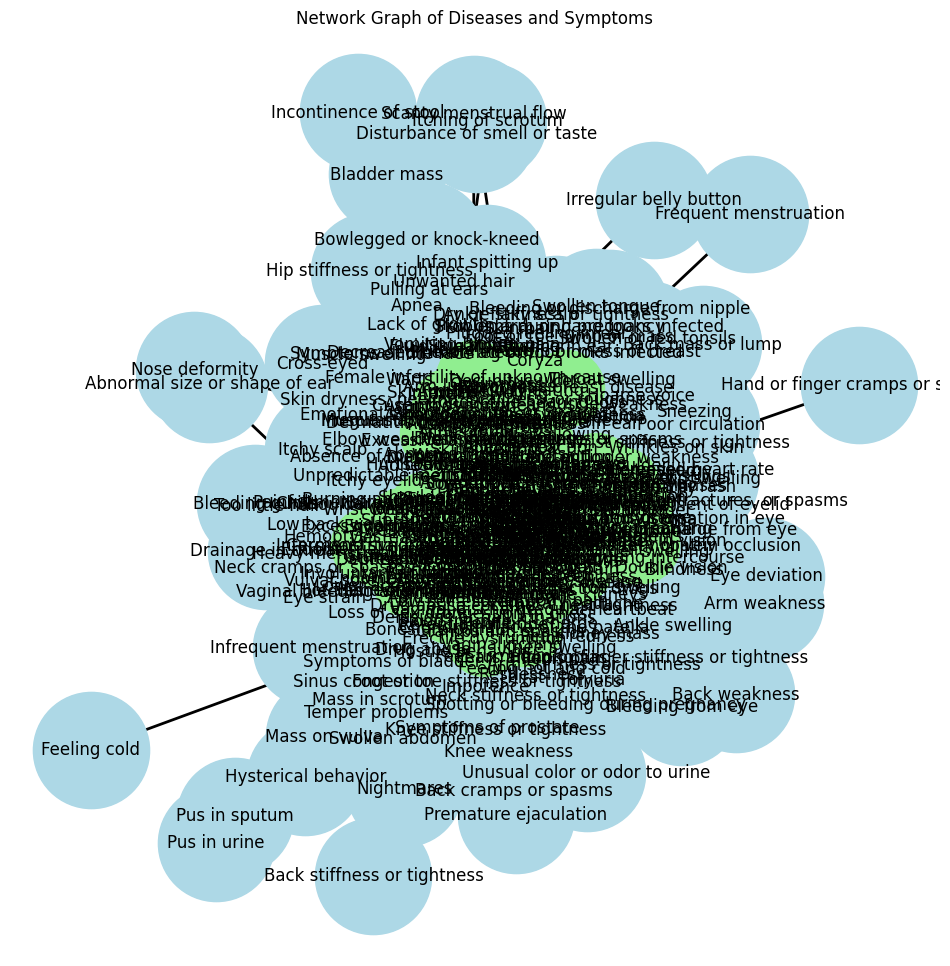

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 객체 생성
G = nx.Graph()

# 질병과 증상을 노드로 추가
for index, row in disease_df.iterrows():
    G.add_node(row['Symptom'], type='symptom')
    G.add_node(row['Disease'], type='disease')
    G.add_edge(row['Symptom'], row['Disease'], weight=row['Count'])

# 그래프 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='lightblue', 
                       nodelist=[node for node in G.nodes() if G.nodes[node]['type'] == 'symptom'])
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightgreen',
                       nodelist=[node for node in G.nodes() if G.nodes[node]['type'] == 'disease'])
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
plt.title('Network Graph of Diseases and Symptoms')
plt.axis('off')
plt.show()